In [1]:
%reset -fs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.metrics import confusion_matrix
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
image_size = (128,128)
batch_size = 32

In [5]:
train_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

Found 10595 files belonging to 9 classes.
Using 8476 files for training.
Found 10595 files belonging to 9 classes.
Using 2119 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']


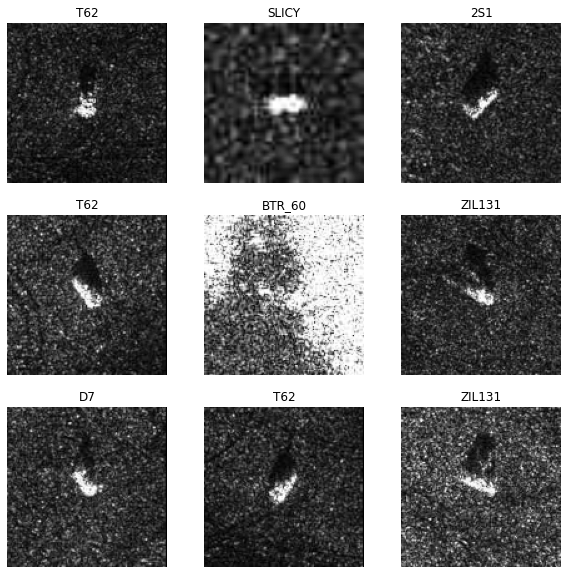

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 1)
(32, 9)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
num_classes=9

metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [11]:
model = keras.Sequential()

model.add(layers.InputLayer(input_shape=(128, 128, 1)))

model.add(layers.Flatten())

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1638500   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 1,659,609
Trainable params: 1,659,609
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)

In [13]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 7s 13ms/step - loss: 71.1235 - tp: 4206.0000 - fp: 4253.0000 - tn: 63555.0000 - fn: 4270.0000 - accuracy: 0.8883 - precision: 0.4972 - recall: 0.4962 - auc: 0.7413 - prc: 0.3749 - val_loss: 5.9517 - val_tp: 1375.0000 - val_fp: 736.0000 - val_tn: 16216.0000 - val_fn: 744.0000 - val_accuracy: 0.9224 - val_precision: 0.6514 - val_recall: 0.6489 - val_auc: 0.8435 - val_prc: 0.5710
Epoch 2/10
265/265 [==============================] - 3s 10ms/step - loss: 4.6042 - tp: 6475.0000 - fp: 1985.0000 - tn: 65823.0000 - fn: 2001.0000 - accuracy: 0.9477 - precision: 0.7654 - recall: 0.7639 - auc: 0.8962 - prc: 0.7109 - val_loss: 3.8042 - val_tp: 1620.0000 - val_fp: 496.0000 - val_tn: 16456.0000 - val_fn: 499.0000 - val_accuracy: 0.9478 - val_precision: 0.7656 - val_recall: 0.7645 - val_auc: 0.8911 - val_prc: 0.6945
Epoch 3/10
265/265 [==============================] - 3s 11ms/step - loss: 2.5651 - tp: 7148.0000 - fp: 1323.0000 - tn: 66485.0000 - 

In [14]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [15]:
def plot_cm(model):
    y_true = []
    y_pred = []
    for x,y in val_ds:
        y= tf.argmax(y,axis=1)
        y_true.append(y)
        y_pred.append(tf.argmax(model.predict(x),axis = 1))
  
    y_pred = tf.concat(y_pred, axis=0)
    y_true = tf.concat(y_true, axis=0)

    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm,cmap='rocket_r', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10},
        cbar = False);
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.show()

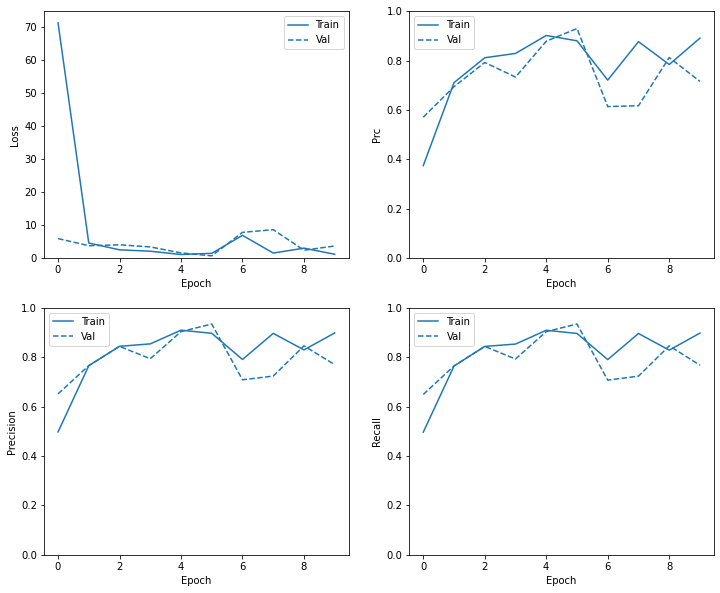

In [16]:
plot_metrics(history)

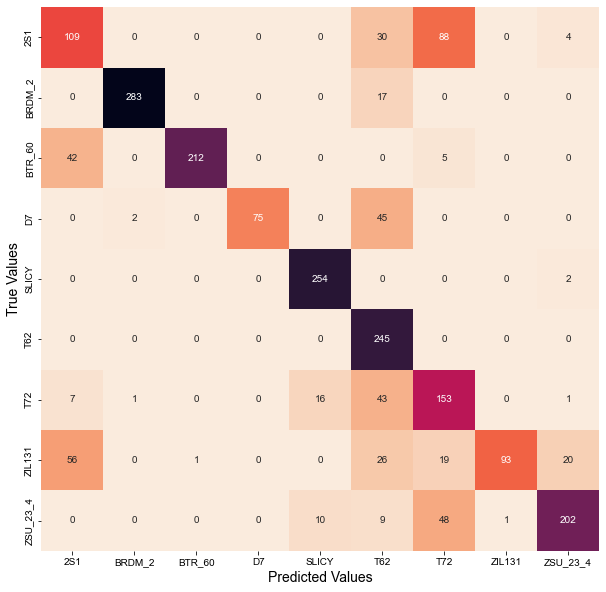

In [17]:
plot_cm(model)

In [18]:

model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
model2.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)

In [20]:
history2 = model2.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 7s 19ms/step - loss: 0.9689 - tp: 5838.0000 - fp: 894.0000 - tn: 83866.0000 - fn: 4757.0000 - accuracy: 0.9407 - precision: 0.8672 - recall: 0.5510 - auc: 0.9278 - prc: 0.7327 - val_loss: 0.1333 - val_tp: 2032.0000 - val_fp: 43.0000 - val_tn: 16909.0000 - val_fn: 87.0000 - val_accuracy: 0.9932 - val_precision: 0.9793 - val_recall: 0.9589 - val_auc: 0.9993 - val_prc: 0.9954
Epoch 2/10
265/265 [==============================] - 4s 15ms/step - loss: 0.1224 - tp: 8134.0000 - fp: 238.0000 - tn: 67570.0000 - fn: 342.0000 - accuracy: 0.9924 - precision: 0.9716 - recall: 0.9597 - auc: 0.9987 - prc: 0.9931 - val_loss: 0.1747 - val_tp: 2002.0000 - val_fp: 97.0000 - val_tn: 16855.0000 - val_fn: 117.0000 - val_accuracy: 0.9888 - val_precision: 0.9538 - val_recall: 0.9448 - val_auc: 0.9971 - val_prc: 0.9863
Epoch 3/10
265/265 [==============================] - 4s 15ms/step - loss: 0.0567 - tp: 8334.0000 - fp: 111.0000 - tn: 67697.0000 - fn: 142.

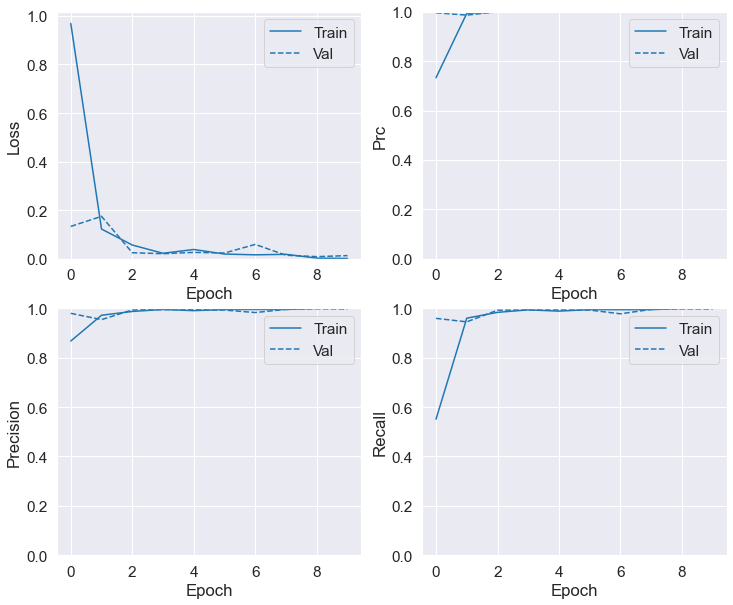

In [21]:
plot_metrics(history2)

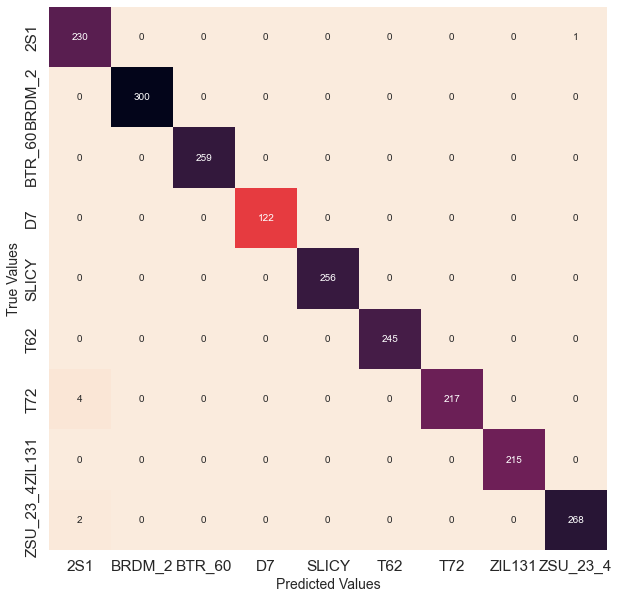

In [22]:
plot_cm(model2)

In [23]:
CNN = Sequential()

CNN.add(layers.InputLayer(input_shape=(128, 128, 1)))


CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))

CNN.add(MaxPooling2D())


CNN.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))

CNN.add(MaxPooling2D())


CNN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))

CNN.add(GlobalAveragePooling2D())


CNN.add(Dense(20, activation='relu'))
CNN.add(Dense(num_classes, activation='softmax'))

CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 10)      100       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 30)        5430      
_________________________________________________________________
global_average_pooling2d (Gl (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)               

In [24]:
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

In [25]:
cnn_hist = CNN.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 6s 16ms/step - loss: 1.7664 - tp: 3220.0000 - fp: 276.0000 - tn: 84484.0000 - fn: 7375.0000 - accuracy: 0.9198 - precision: 0.9211 - recall: 0.3039 - auc: 0.8630 - prc: 0.5974 - val_loss: 1.4380 - val_tp: 623.0000 - val_fp: 214.0000 - val_tn: 16738.0000 - val_fn: 1496.0000 - val_accuracy: 0.9103 - val_precision: 0.7443 - val_recall: 0.2940 - val_auc: 0.8619 - val_prc: 0.5446
Epoch 2/10
265/265 [==============================] - 3s 13ms/step - loss: 0.8800 - tp: 4063.0000 - fp: 579.0000 - tn: 67229.0000 - fn: 4413.0000 - accuracy: 0.9346 - precision: 0.8753 - recall: 0.4794 - auc: 0.9531 - prc: 0.7772 - val_loss: 0.6513 - val_tp: 1259.0000 - val_fp: 141.0000 - val_tn: 16811.0000 - val_fn: 860.0000 - val_accuracy: 0.9475 - val_precision: 0.8993 - val_recall: 0.5941 - val_auc: 0.9752 - val_prc: 0.8605
Epoch 3/10
265/265 [==============================] - 3s 12ms/step - loss: 0.6714 - tp: 5063.0000 - fp: 879.0000 - tn: 66929.0000 - fn: 

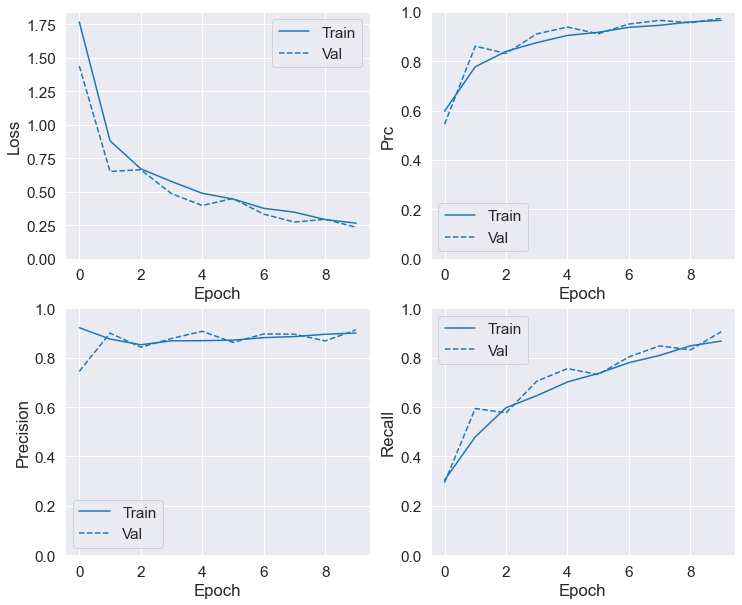

In [26]:
plot_metrics(cnn_hist)

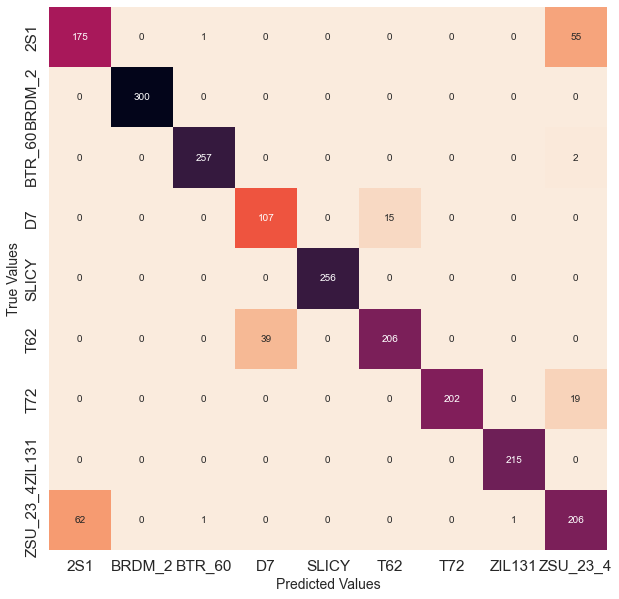

In [27]:
plot_cm(CNN)

In [28]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(128,128),
  layers.Rescaling(1./255)])

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
    ]
)

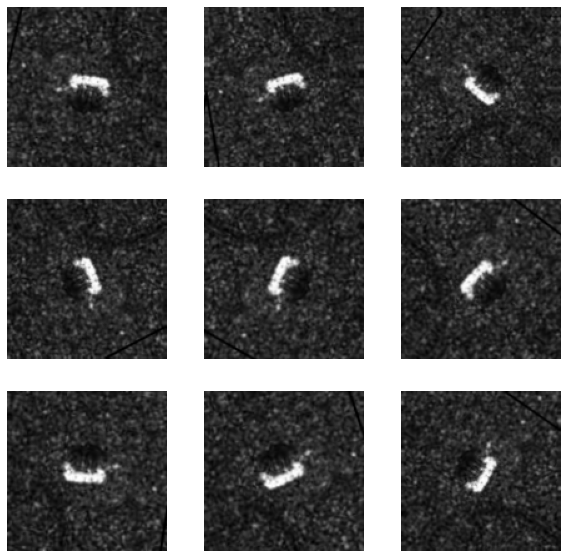

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [31]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


xception = make_model(input_shape=image_size + (1,), num_classes=9)
xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 128, 128, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 128, 128, 1)  0           sequential_3[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         sequential_4[0][0]               
______________________________________________________________________________________________

In [32]:
callbacks=[
        keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor='val_recall', mode='max', restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]
xception.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,
)
xception_hist = xception.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
265/265 [==============================] - 28s 90ms/step - loss: 1.1514 - tp: 5691.0000 - fp: 1628.0000 - tn: 83132.0000 - fn: 4904.0000 - accuracy: 0.9315 - precision: 0.7776 - recall: 0.5371 - auc: 0.9405 - prc: 0.7434 - val_loss: 5.1115 - val_tp: 0.0000e+00 - val_fp: 30.0000 - val_tn: 16922.0000 - val_fn: 2119.0000 - val_accuracy: 0.8873 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5191 - val_prc: 0.1183
Epoch 2/100
265/265 [==============================] - 22s 84ms/step - loss: 0.5666 - tp: 6305.0000 - fp: 1181.0000 - tn: 66627.0000 - fn: 2171.0000 - accuracy: 0.9561 - precision: 0.8422 - recall: 0.7439 - auc: 0.9787 - prc: 0.8840 - val_loss: 8.1817 - val_tp: 544.0000 - val_fp: 1423.0000 - val_tn: 15529.0000 - val_fn: 1575.0000 - val_accuracy: 0.8428 - val_precision: 0.2766 - val_recall: 0.2567 - val_auc: 0.6054 - val_prc: 0.2725
Epoch 3/100
265/265 [==============================] - 22s 85ms/step - loss: 0.4006 - tp: 6999.0000 - fp: 932.0000 - tn:

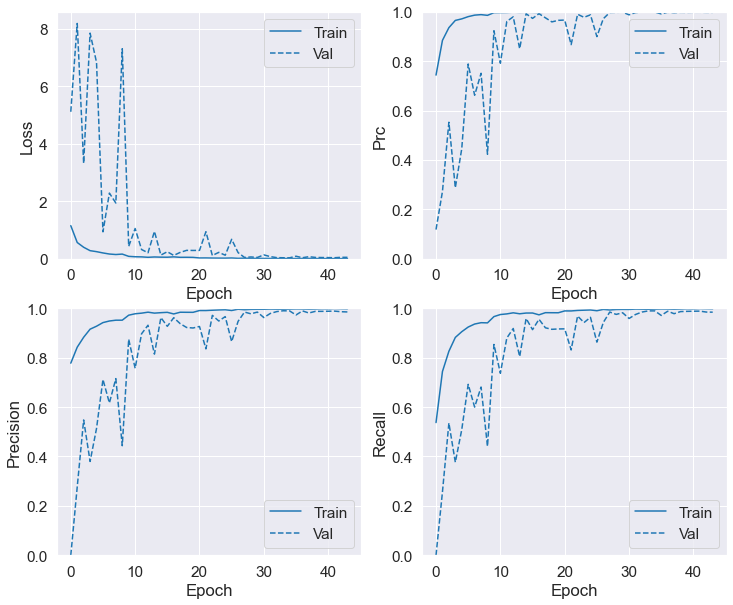

In [33]:
plot_metrics(xception_hist)

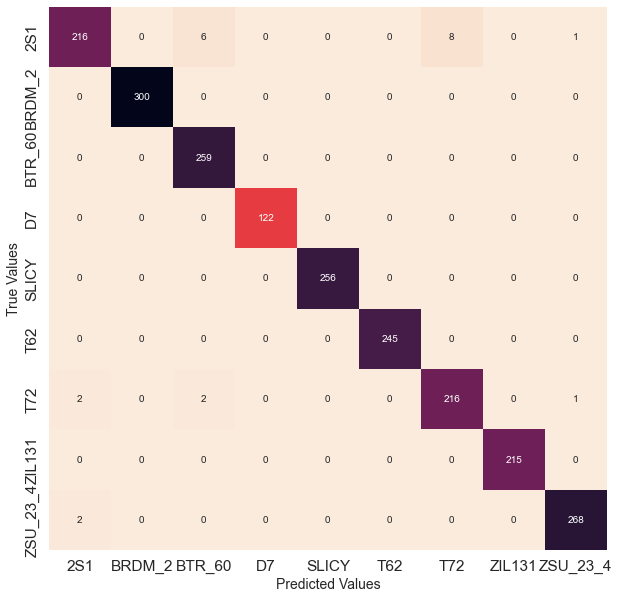

In [34]:
plot_cm(xception)